In [1]:
# from utils.binaries import *
# from utils.plotting import *

from matplotlib.gridspec import GridSpec
from scipy.interpolate import griddata
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

import scienceplots
plt.style.use(['science', 'ieee'])

In [ ]:
from matplotlib.gridspec import GridSpec
from utils.binaries import *
from utils.plotting import *

In [2]:
def load_file(pickle_location: str):
    with open(pickle_location, 'rb') as f:
        return pickle.load(f)
    
def select_hist(data, bins, cuts, ax=None, **kwargs):

    if ax is None: ax = plt.gca()
    data = np.array(data)
    orientation = kwargs.get('orientation', 'vertical')
    c = kwargs.get('color', 'k')

    select = np.ma.masked_where(((cuts[0] <= data) & (data < cuts[1])), data).mask
    percentage_accept = (1 - (len(data) - sum(select)) / len(data)) * 100
    # _ = ax.hist(data, bins=bins, label=f'accept {percentage_accept:.1f}%', histtype='step', align='mid', orientation=orientation, color='k')
    _ = ax.hist(data, bins=bins, histtype='step', align='mid', orientation=orientation, color='k')
    _ = ax.hist(data[select], bins=bins, fc='g', alpha=0.5, align='mid', orientation=orientation, color='k')
    _ = ax.hist(data[~select], bins=bins, fc='r', alpha=0.5, align='mid', orientation=orientation, color='k')

    for cut in cuts:
        if orientation == 'horizontal':
            ax.axhline(cut, ls='-.', alpha=0.2, zorder=0)
        else:
            ax.axvline(cut, ls='-.', alpha=0.2, zorder=0)

    ax.text(1 if orientation == 'horizontal' else 0, 1, 
            rf"$\mu\,=\,{np.nanmean(data):.2f}$, $\sigma\,=\,{np.nanstd(data):.3f}$",
            transform=ax.transAxes,
            ha='left',
            va='top' if orientation == 'horizontal' else 'bottom',
            rotation=-90 if orientation == 'horizontal' else 0)

    return select

def AddApertureEtcToPlot(ax, unit='mm', filterStructure=True, zorder=10):
    """
    Adds Aperture, Lens, Filterstructure (of most telescopes) to an given axis ax!
    args: axis, unit
    return: nothing
    """
    if unit == 'mm':
        uf = 1
        ax.set_xlabel(r'$x$ / mm')
        ax.set_ylabel(r'$y$ / mm')
    elif unit == 'm':
        uf = 1e-3
        ax.set_xlabel(r'$x$ / m')
        ax.set_ylabel(r'$y$ / m')
    else:
        raise ValueError('Only m and mm are supported!')
    aperture = plt.Circle((0, 0), 1100 * uf, color='tab:red', fill=False, lw=2, zorder=zorder, alpha=0.5)
    ax.add_artist(aperture)
    corrector = plt.Circle((0, 0), 1700 / 2 * uf, color='k', fill=False, ls='--', zorder=zorder)
    if filterStructure:
        ax.plot([-1030 * uf, 1030 * uf], [765 * uf / 2] * 2, color='grey', alpha=0.6, lw=0.6, zorder=0, ls='solid')
        ax.plot([-1030 * uf, 1030 * uf], [-765 * uf / 2] * 2, color='grey', alpha=0.6, lw=0.6, zorder=0, ls='solid')
        ax.plot([-450 * uf / 2] * 2, [-1078 * uf, 1076 * uf], color='grey', alpha=0.6, lw=0.6, zorder=0, ls='solid')
        ax.plot([450 * uf / 2] * 2, [-1078 * uf, 1076 * uf], color='grey', alpha=0.6, lw=0.6, zorder=0, ls='solid')

        ax.plot([450 * uf / 2 + 460 * uf] * 2, [-850 * uf, 850 * uf], color='grey', alpha=0.3, lw=0.3, zorder=0, ls='solid')
        ax.plot([-450 * uf / 2 - 460 * uf] * 2, [-850 * uf, 850 * uf], color='grey', alpha=0.3, lw=0.3, zorder=0, ls='solid')
    ax.add_artist(corrector)
    ax.set_xlim(-1300 * uf, 1300 * uf)
    ax.set_ylim(-1300 * uf, 1300 * uf)
    ax.set_aspect('equal', 'box')

    return aperture, corrector

In [3]:
base = '/home/filip/xy-calibration/QualityControl'
# base = '/cr/data01/filip/xy-calibration/QualityAssurance'

t_led, t_phd = [], []
drift_t_led, drift_t_phd = [], []
noise_phd, drift_phd = [], []
x, y, s = [], [], []
mean_x, mean_y = [], []
cal_a_ratios = []
std_calib_ratios = []
count = 0

telescopes = {
    'HEAT pre cleaning': ['6020x', '6025', '6031x', 
                          '05616x', '05621x', '05626x'],
    'HEAT post cleaning': ['6066', '6070', '6075', '6101'],
    'Los Leones': ['15672', '15675',
                   '14453'], # '14443',],
    'Loma Amarilla': ['12275x', '12279x', '12292x', '12301x', '12307x', '12320x', '12328x',
                      '11863', '11875', ''],
    'Coihueco': ['15920x', '15925x', '15934x', '15941x', '15952x', '15959', '15967', '15984x',
                 '15437', '15443x', '15448', '15468',
                 '15490x'],
    'Los Morados': ['12806', '12809', '12819', '12822', '12825', '12830']
}
tel_std_calib_ratios = {}

for telescope, runs in telescopes.items():

    tel = []
    for run in runs:
        try:
            data = load_file(f"{base}/{run}.pkl")
            t_led += list(data['t_led'])
            t_phd += list(data['t_phd'])

            drift_t_led.append(np.corrcoef(data['t_led'], data['time'])[0, 1])
            drift_t_phd.append(np.corrcoef(data['t_phd'], data['time'])[0, 1])
            noise_phd.append(np.std(data['phd_signal']) / np.mean(data['phd_signal']))
            drift_phd.append(np.corrcoef(data['phd_signal'], data['time'])[0, 1])

            xs, ys, f = data['flashes']
            x += list(xs)
            y += list(ys) 
            s += list(f / f.max())

            signal_sum = f.sum()
            mean_x.append((xs * f / signal_sum).sum())
            mean_y.append((ys * f / signal_sum).sum())

            cal_a_ratios += list(data['cal_before'] / data['cal_after'])
            std_calib_ratio = list(data['xy_corr'] / data['std_calib'])

            std_calib_ratios += std_calib_ratio
            tel += std_calib_ratio

            count += 1

        except FileNotFoundError:
            print(f'{telescope}: {run} not found')
            continue
        except KeyError:
            print(run)

    tel_std_calib_ratios[telescope] = tel

for file in os.listdir(base):
    if not file.endswith('.pkl'): continue
    count += 1


Los Leones: 14453 not found
Loma Amarilla: 11863 not found
Loma Amarilla:  not found
Coihueco: 15490x not found
Los Morados: 12819 not found


/tmp/ipykernel_10014/71692545.py:52: RuntimeWarning: divide by zero encountered in divide
  std_calib_ratio = list(data['xy_corr'] / data['std_calib'])


/tmp/ipykernel_10014/633095856.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()
/tmp/ipykernel_10014/633095856.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax2.legend()


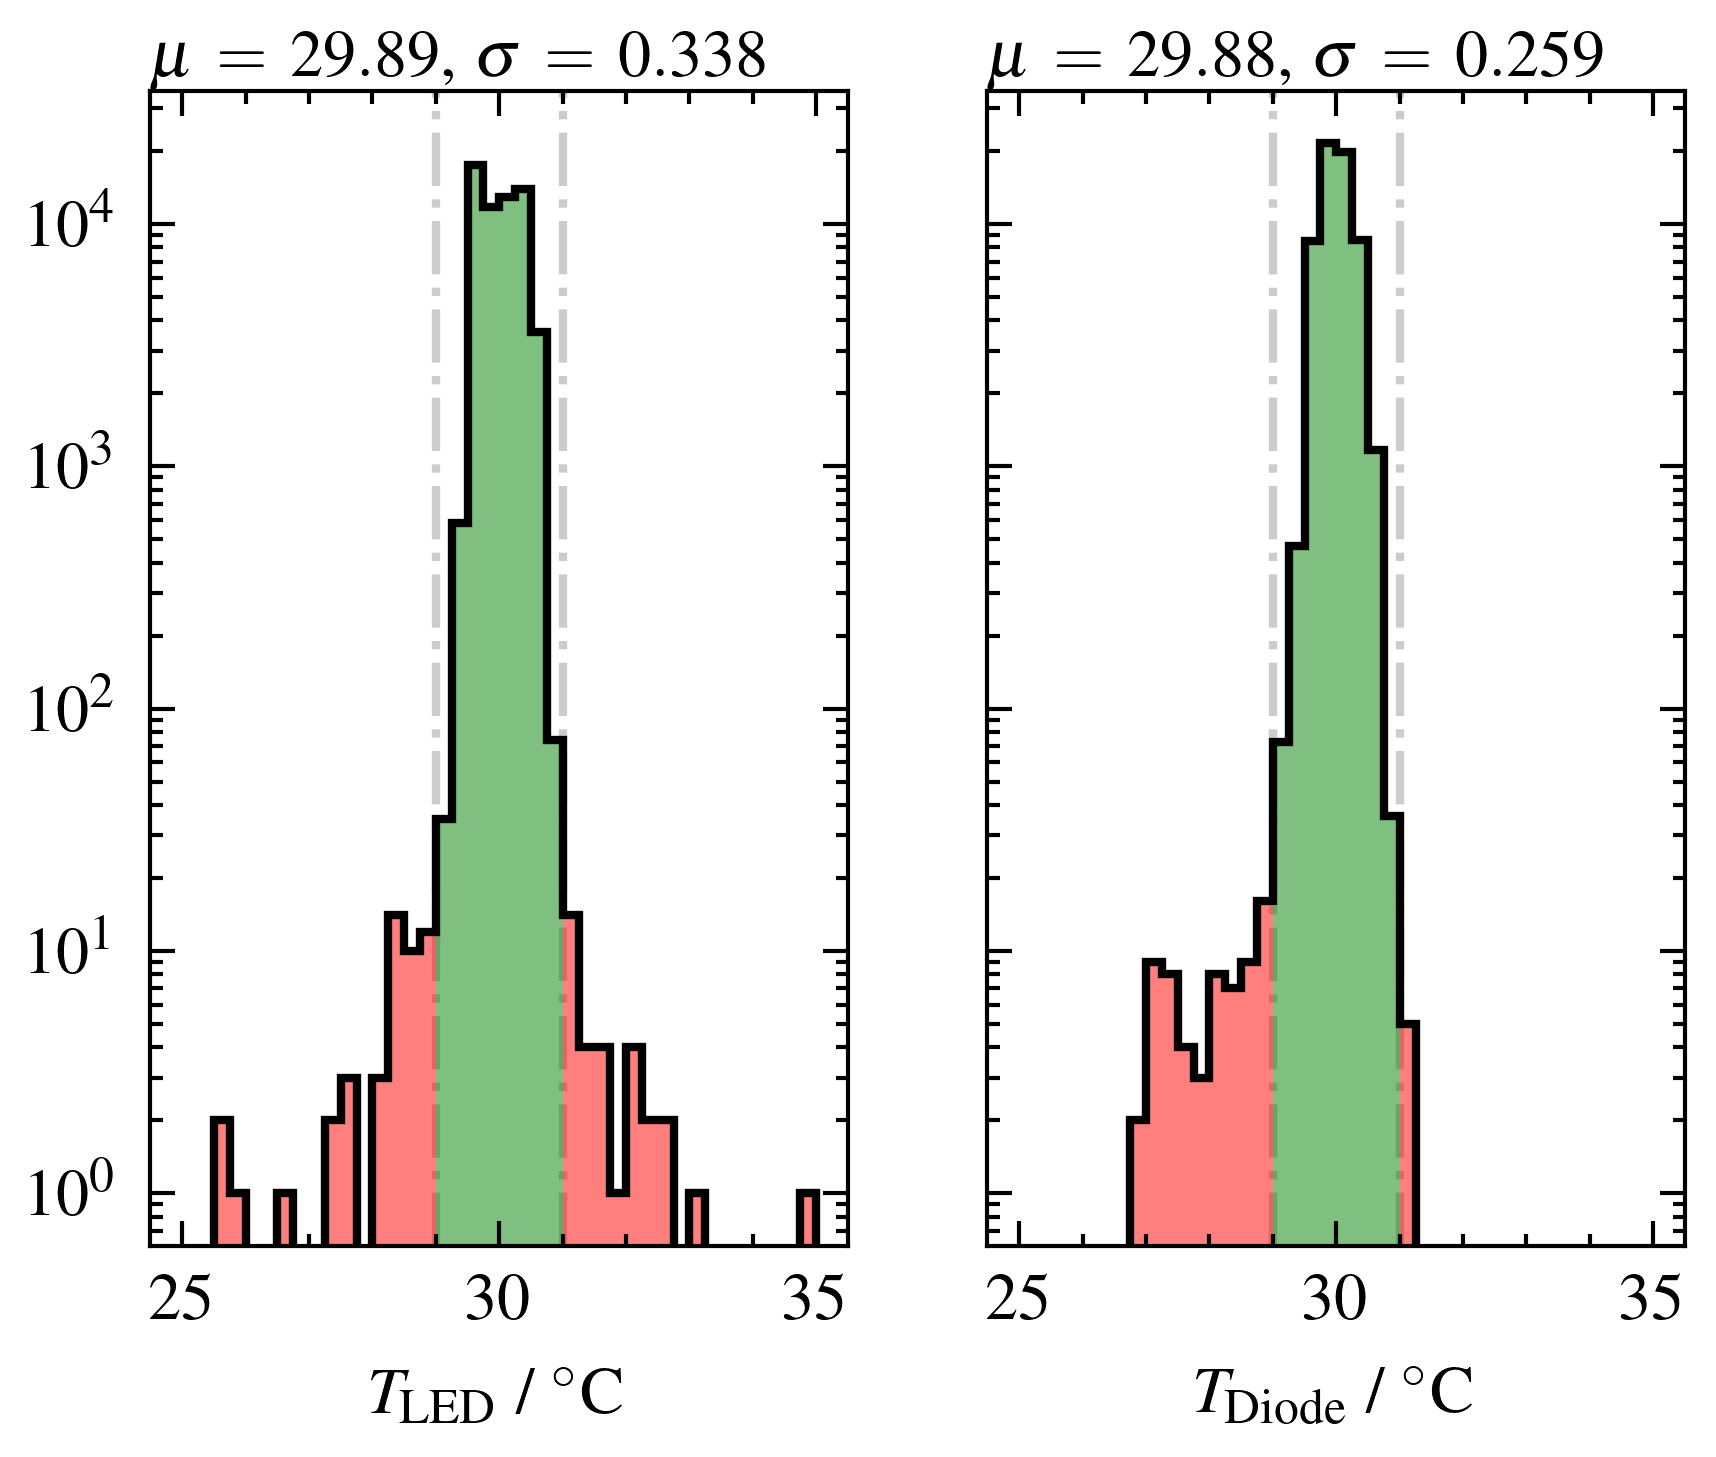

In [4]:
# Temperature

temp_bins = np.linspace(25, 35, 41)

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True)

# _ = ax1.hist(t_led, bins=temp_bins, histtype='step')
_ = select_hist(t_led, temp_bins, [29, 31], ax1, color='k')
ax1.set_yscale('log')
# ax1.set_yticks([])
ax1.set_xlabel('$T_\mathrm{LED}$ / $^\circ$C')
ax1.legend()

# _ = ax2.hist(t_phd, bins=temp_bins, histtype='step')
_ = select_hist(t_phd, temp_bins, [29, 31], ax2, color='k')
ax2.set_yscale('log')
# ax2.set_yticks([])
ax2.set_xlabel('$T_\mathrm{Diode}$ / $^\circ$C')
ax2.legend()

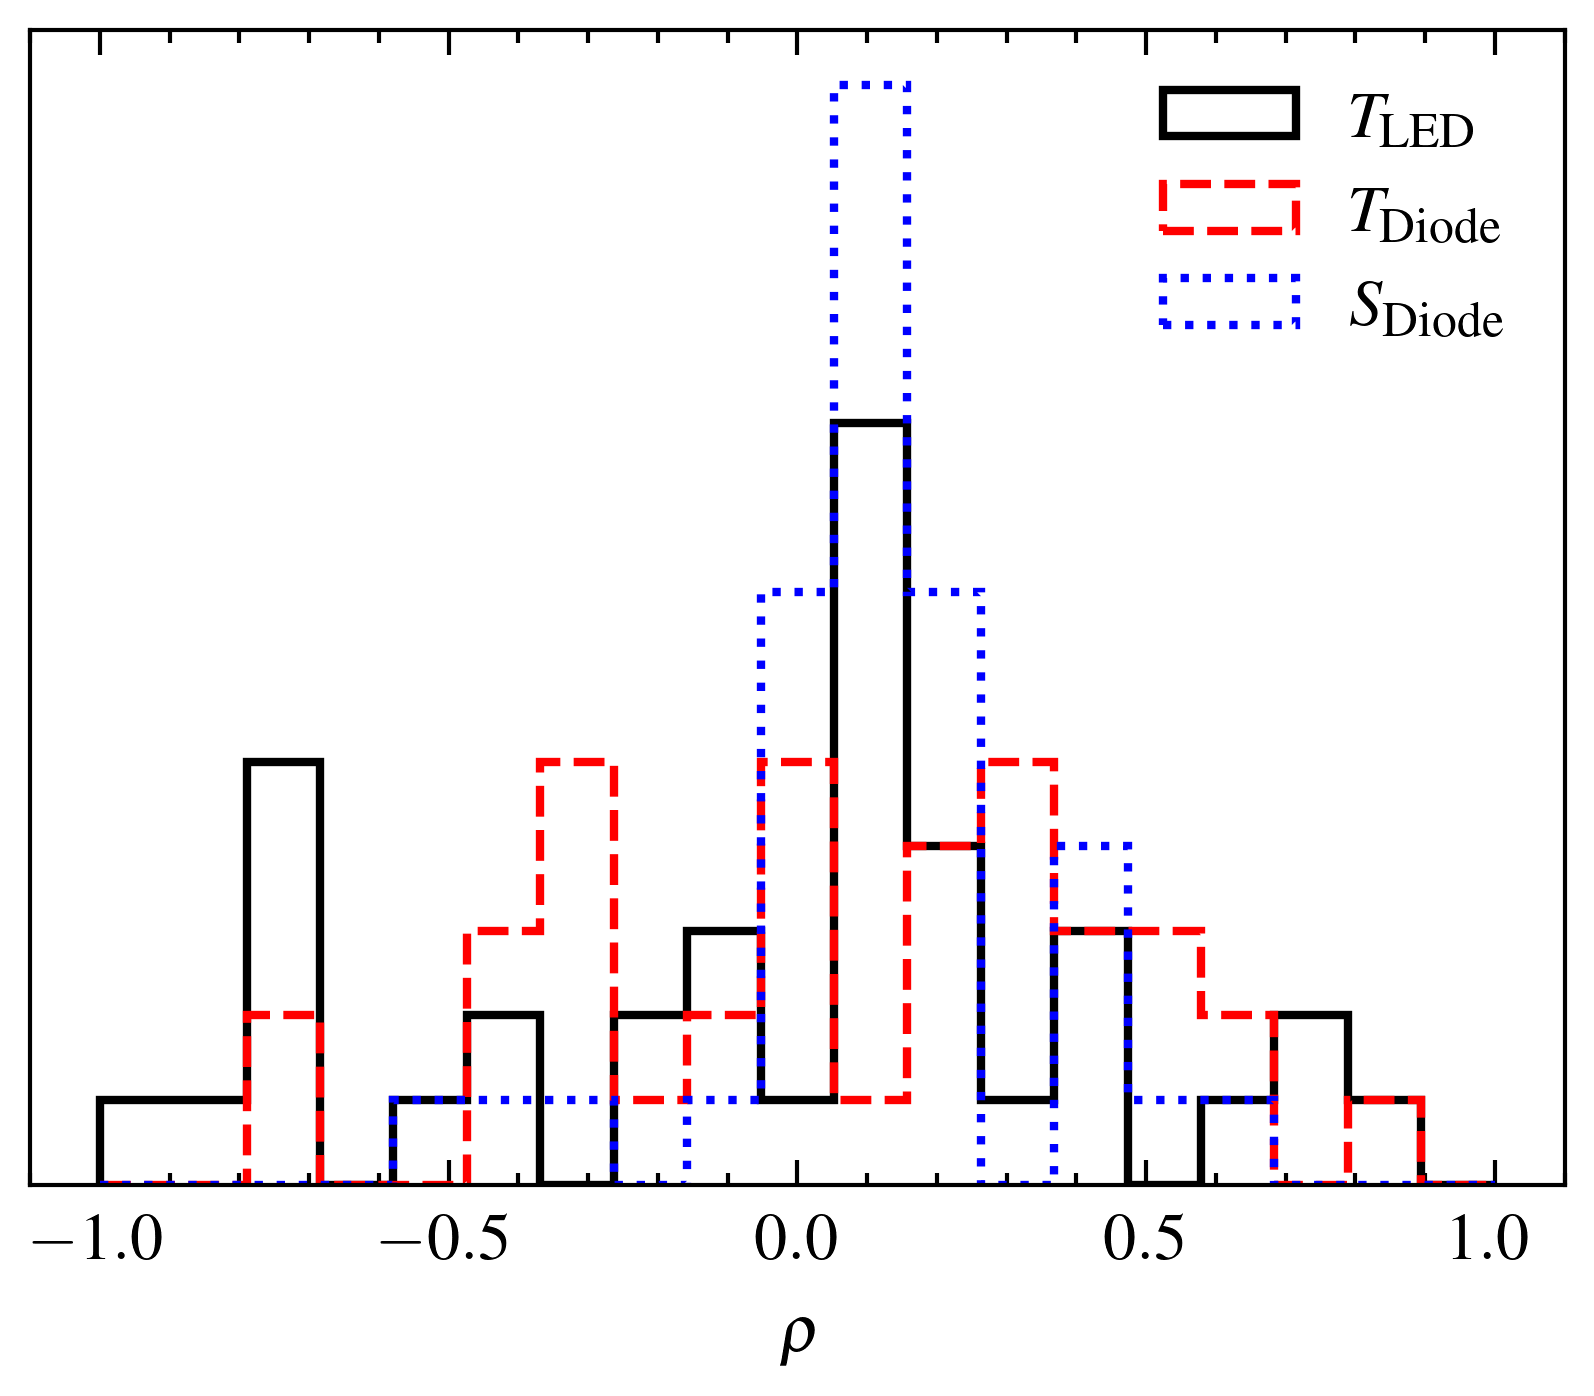

In [5]:
# Drift

drift_bins = np.linspace(-1, 1, 20)

_ = plt.hist(drift_t_led, bins=drift_bins, histtype='step', label=r"$T_\mathrm{LED}$")
_ = plt.hist(drift_t_phd, bins=drift_bins, histtype='step', label=r"$T_\mathrm{Diode}$")
_ = plt.hist(drift_phd, bins=drift_bins, histtype='step', label=r"$S_\mathrm{Diode}$")

plt.xlabel(r'$\rho$')
plt.yticks([])
plt.legend()

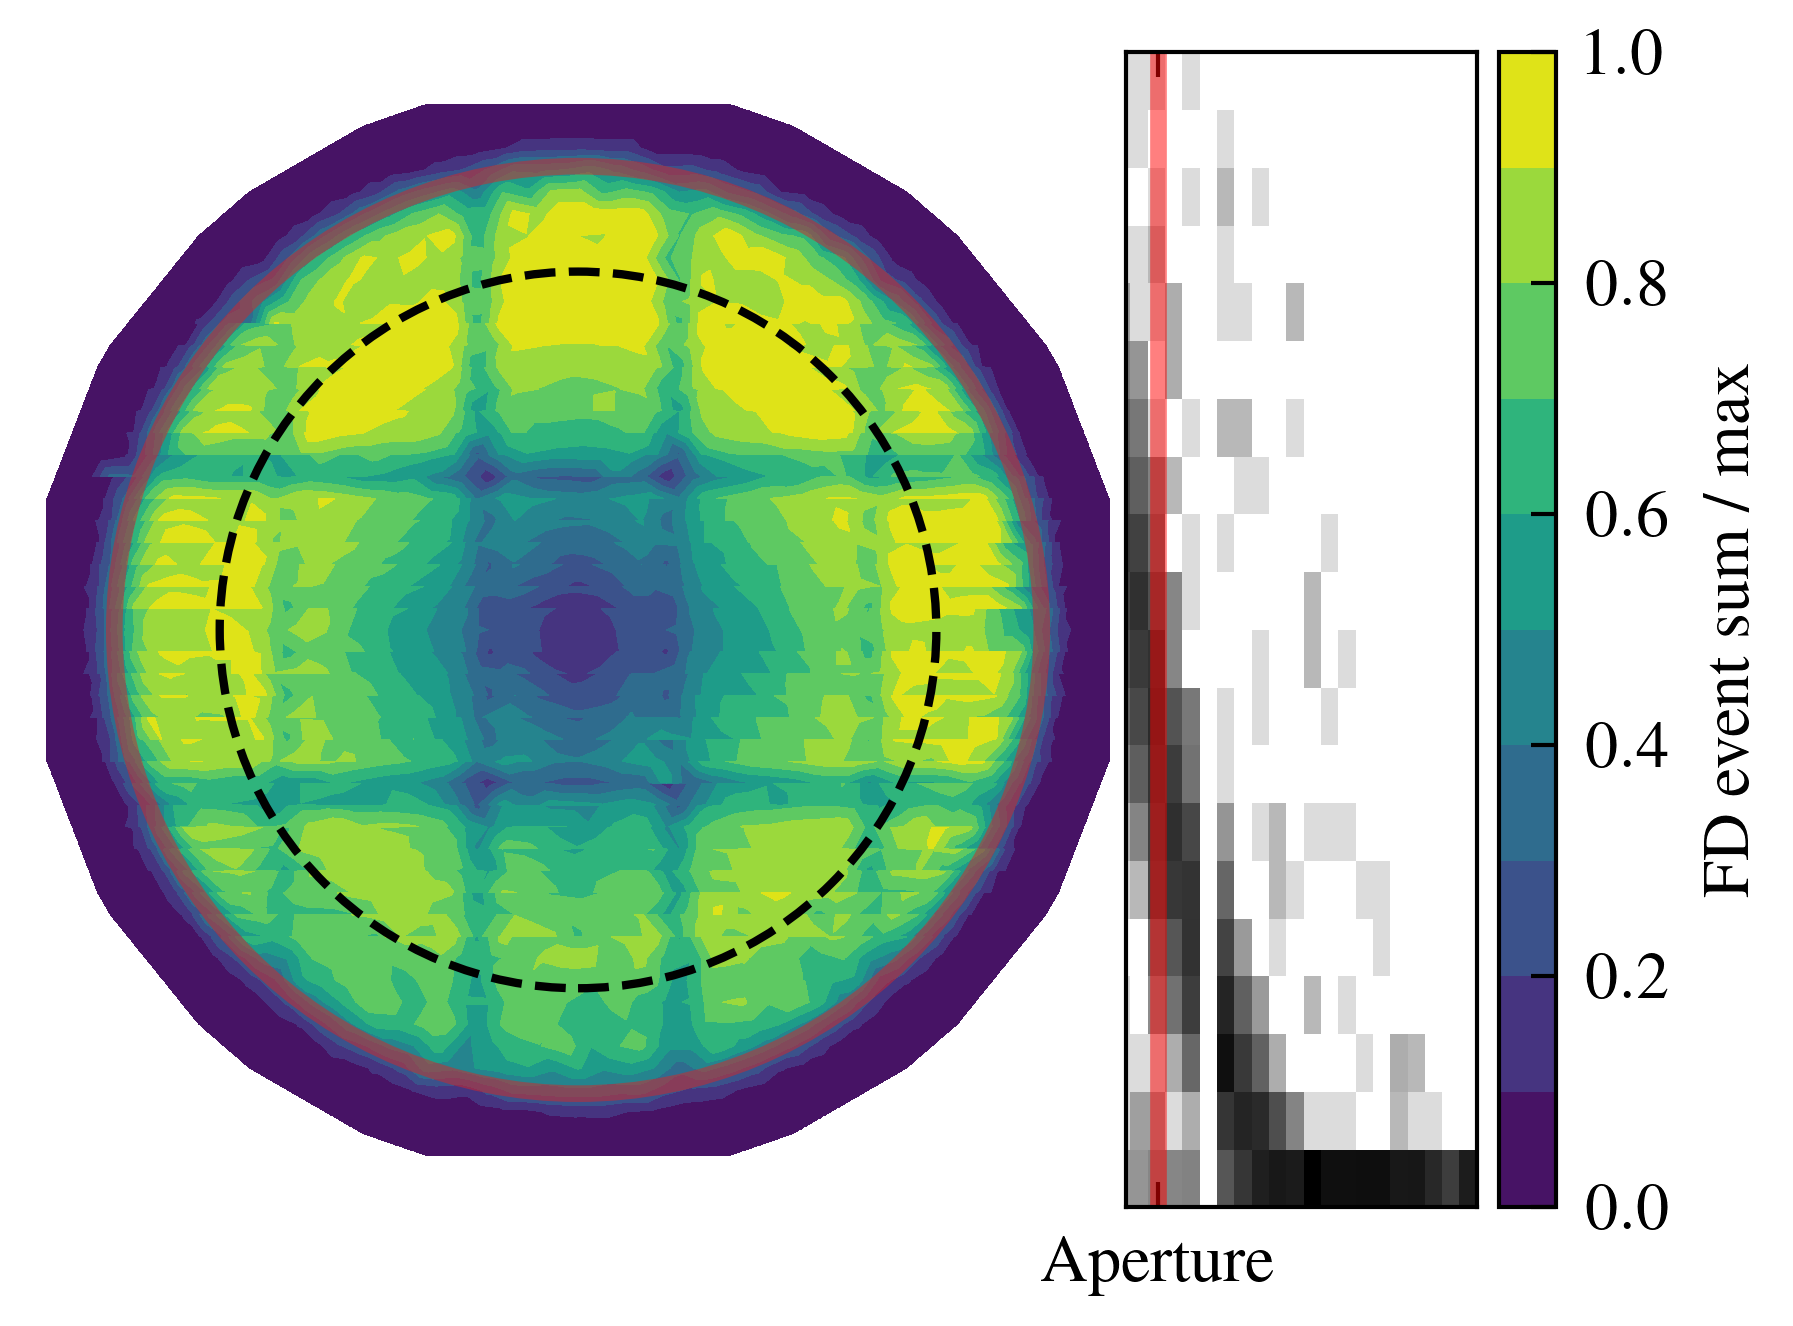

In [23]:
# curtain check

fig, (ax1, ax2) = plt.subplots(1, 2, width_ratios=[1, 0.4])

xii = yii = np.arange(-1300,1300,1)
xi,yi = np.meshgrid(xii,yii)
zi = griddata((x,y),s,(xi,yi),method='linear')

AddApertureEtcToPlot(ax1)
contour = ax1.contourf(xi,yi,zi, np.linspace(0, 1, 11, endpoint=True))

_ = ax2.hist2d(np.sqrt(np.array(x)**2 + np.array(y)**2), s, bins=[120, 20], norm='symlog', cmap='binary')
plt.colorbar(contour, ax=ax2, label='FD event sum / max')
ax2.axvline(1100, c='r', lw=2, alpha = 0.5)
ax2.axvline(850, c='k', ls='--')
ax2.set_xlim(1080)
ax2.set_yticks([])
ax2.set_xticks([1100], ['Aperture'])
ax1.axis('off')
# ax2.set_xscale('log')

plt.subplots_adjust(wspace=0)

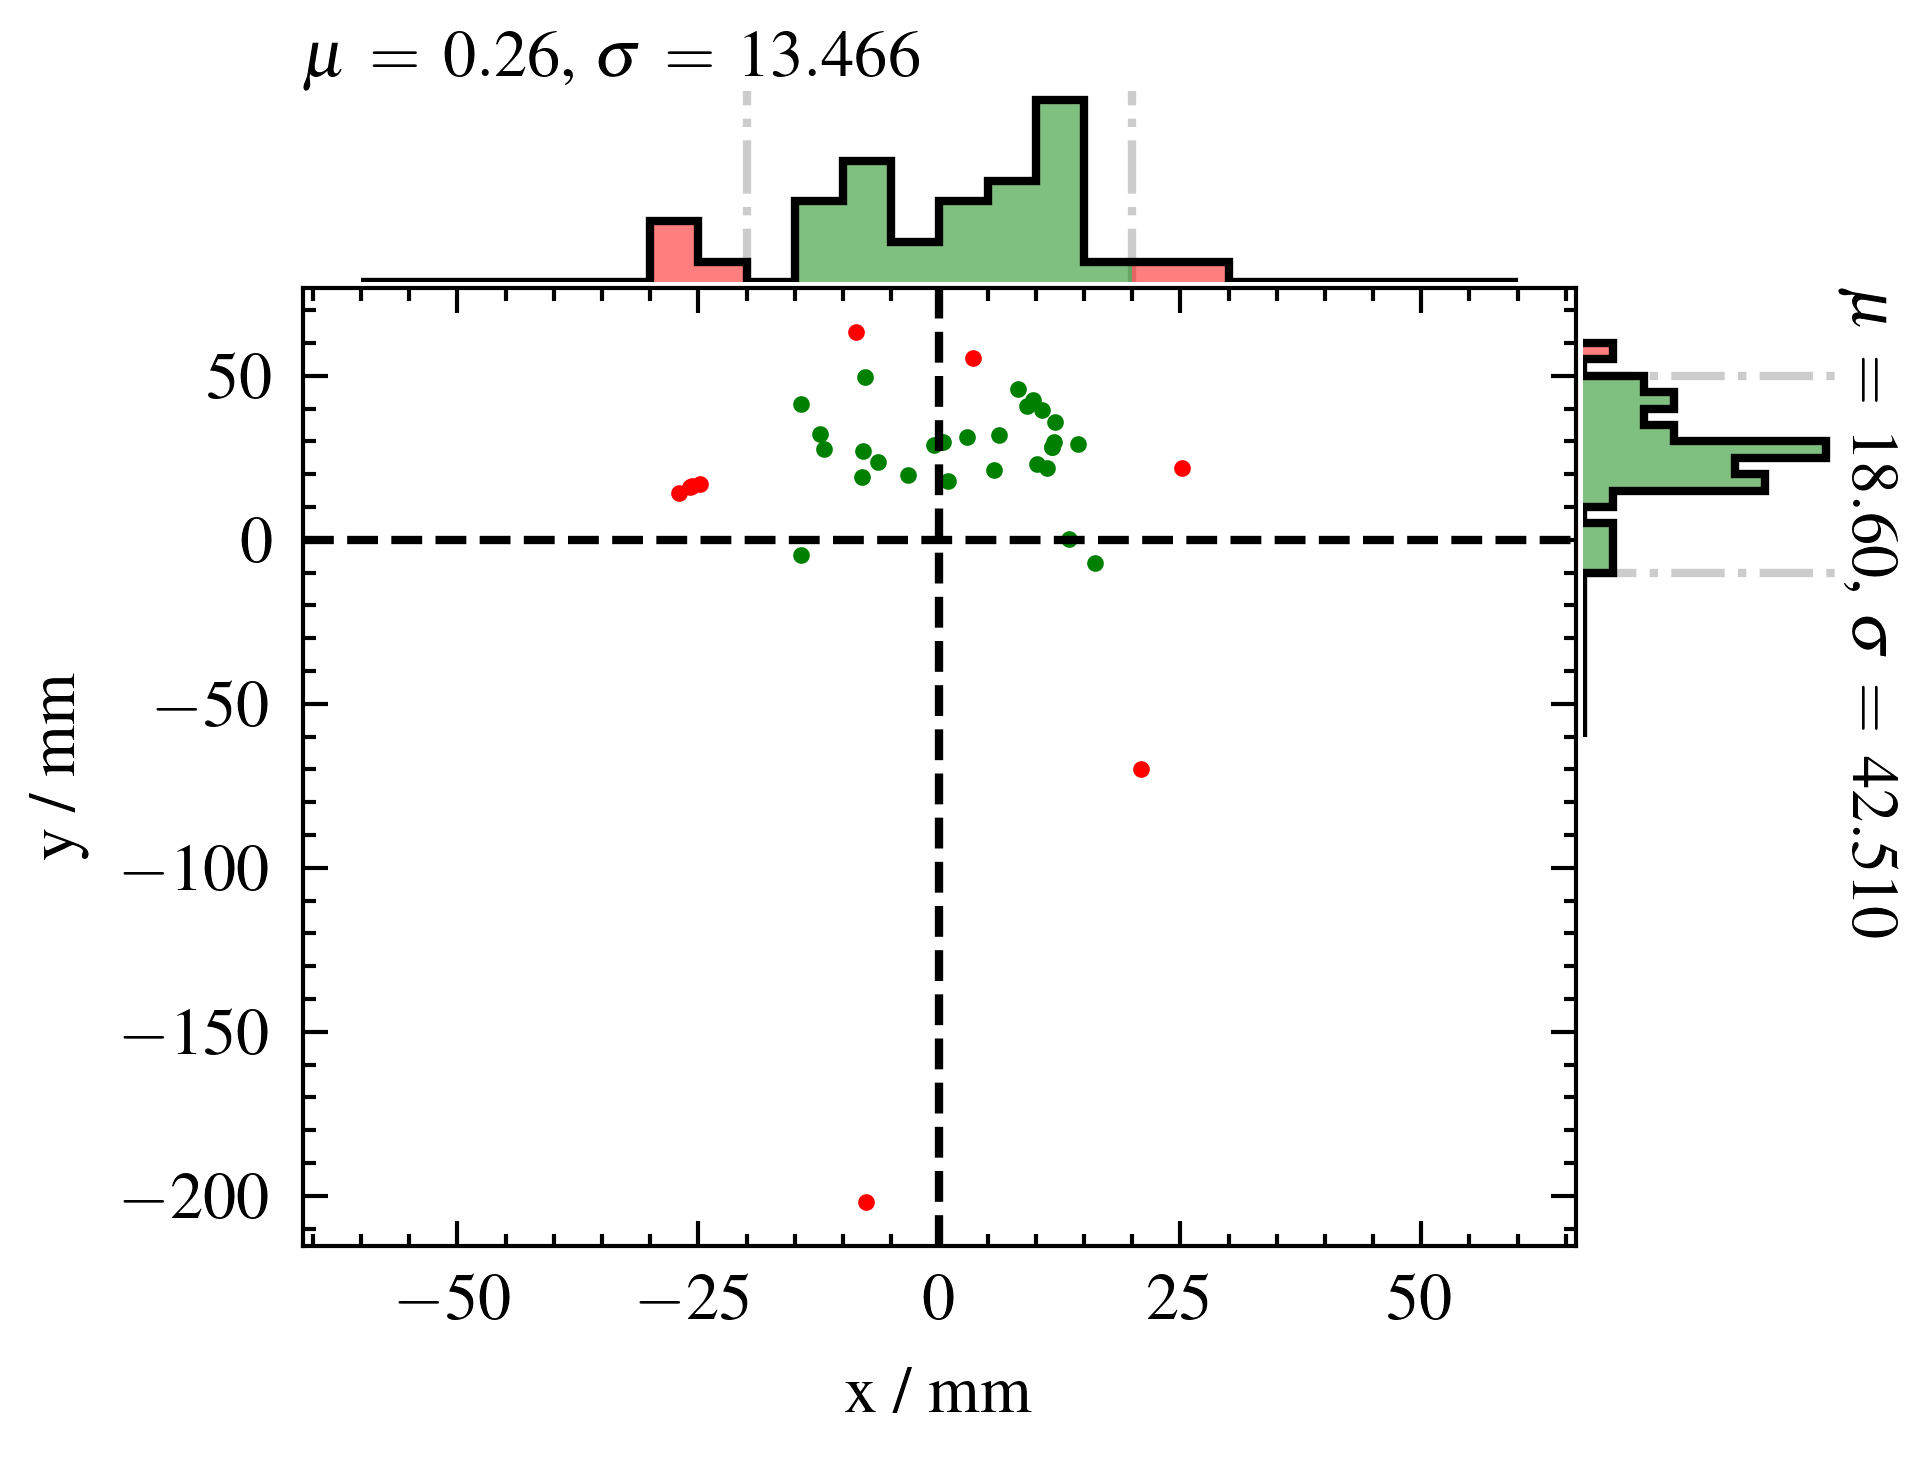

In [26]:
# anisotropy

ani_bins = np.arange(-60, 61, 5)

fig = plt.figure()

gs = GridSpec(
    2, 2,
    width_ratios=[1, 0.2],
    height_ratios=[0.2, 1],
)

ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[0, 0], sharex=ax1)
ax3 = fig.add_subplot(gs[1, 1], sharey=ax1)

ax2.axis('off')
ax3.axis('off')

sel_x = select_hist(mean_x, ani_bins, [-20, 20], ax2, c='k')
sel_y = select_hist(mean_y, ani_bins, [-10, 50], ax3, c='k', orientation='horizontal')
select_mask = sel_x & sel_y

ax1.scatter(np.array(mean_x)[~select_mask], np.array(mean_y)[~select_mask], c='r', s=1)
ax1.scatter(np.array(mean_x)[select_mask], np.array(mean_y)[select_mask], c='g', s=1)
ax1.axvline(0, c='k', ls='--')
ax1.axhline(0, c='k', ls='--')
ax1.set_xlabel('x / mm')
ax1.set_ylabel('y / mm')

plt.subplots_adjust(hspace=0.01, wspace=0.01)

/tmp/ipykernel_10014/4038834212.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


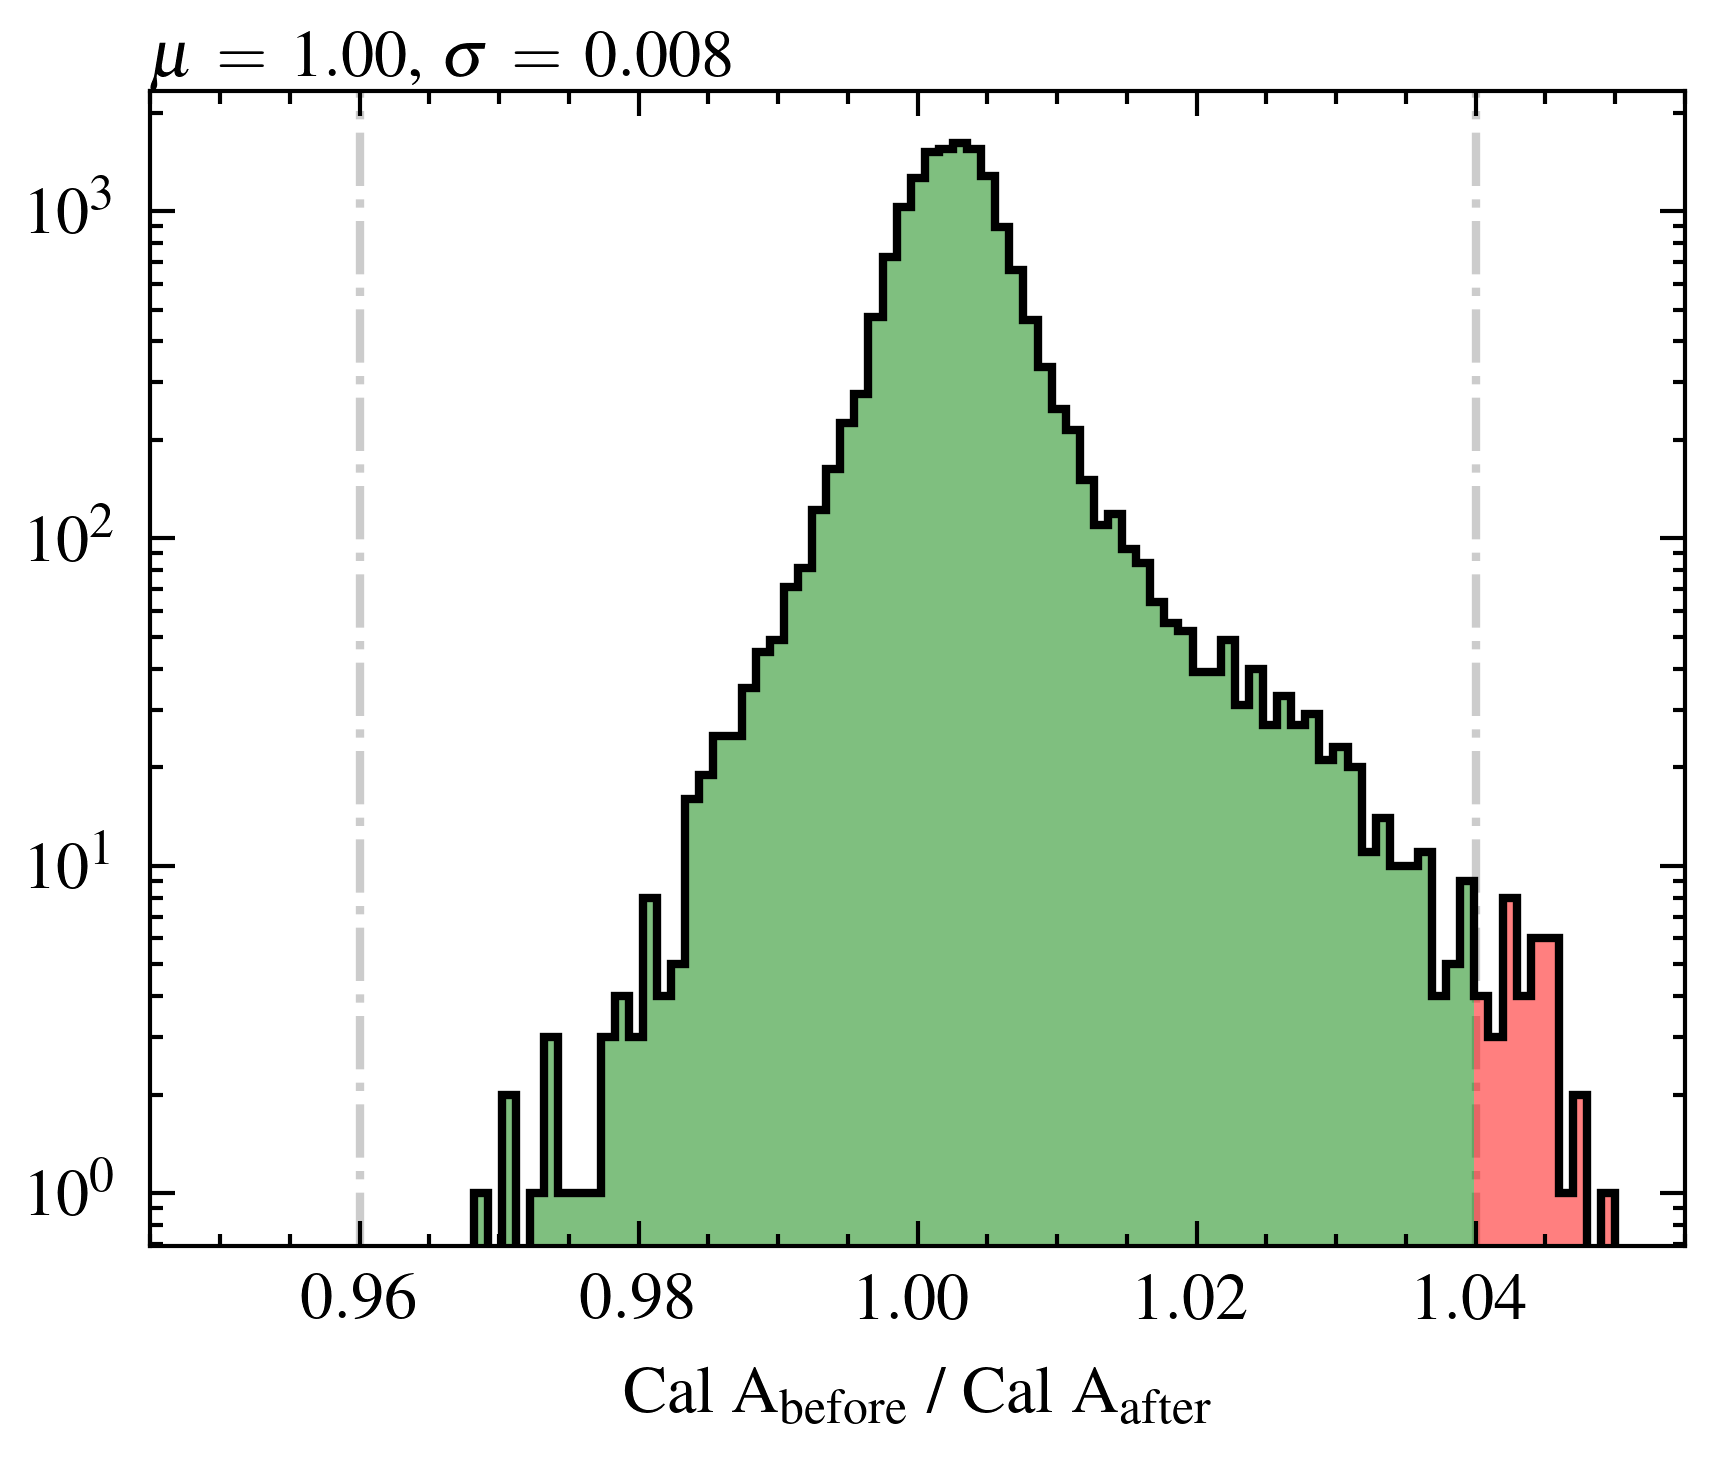

In [28]:
# cal a stability

cal_a_bins = np.linspace(0.95, 1.05, 100)

cal_a_ratios = np.array(cal_a_ratios)
cal_a_ratios[~np.isfinite(cal_a_ratios)] = 1

_ = select_hist(cal_a_ratios, bins=cal_a_bins, cuts=[0.96, 1.04], ax=plt.gca())
plt.xlabel(r'Cal A$_\mathrm{before}$ / Cal A$_\mathrm{after}$')
plt.yticks([])
plt.legend()
plt.yscale('log')

/tmp/ipykernel_10014/2935180495.py:41: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


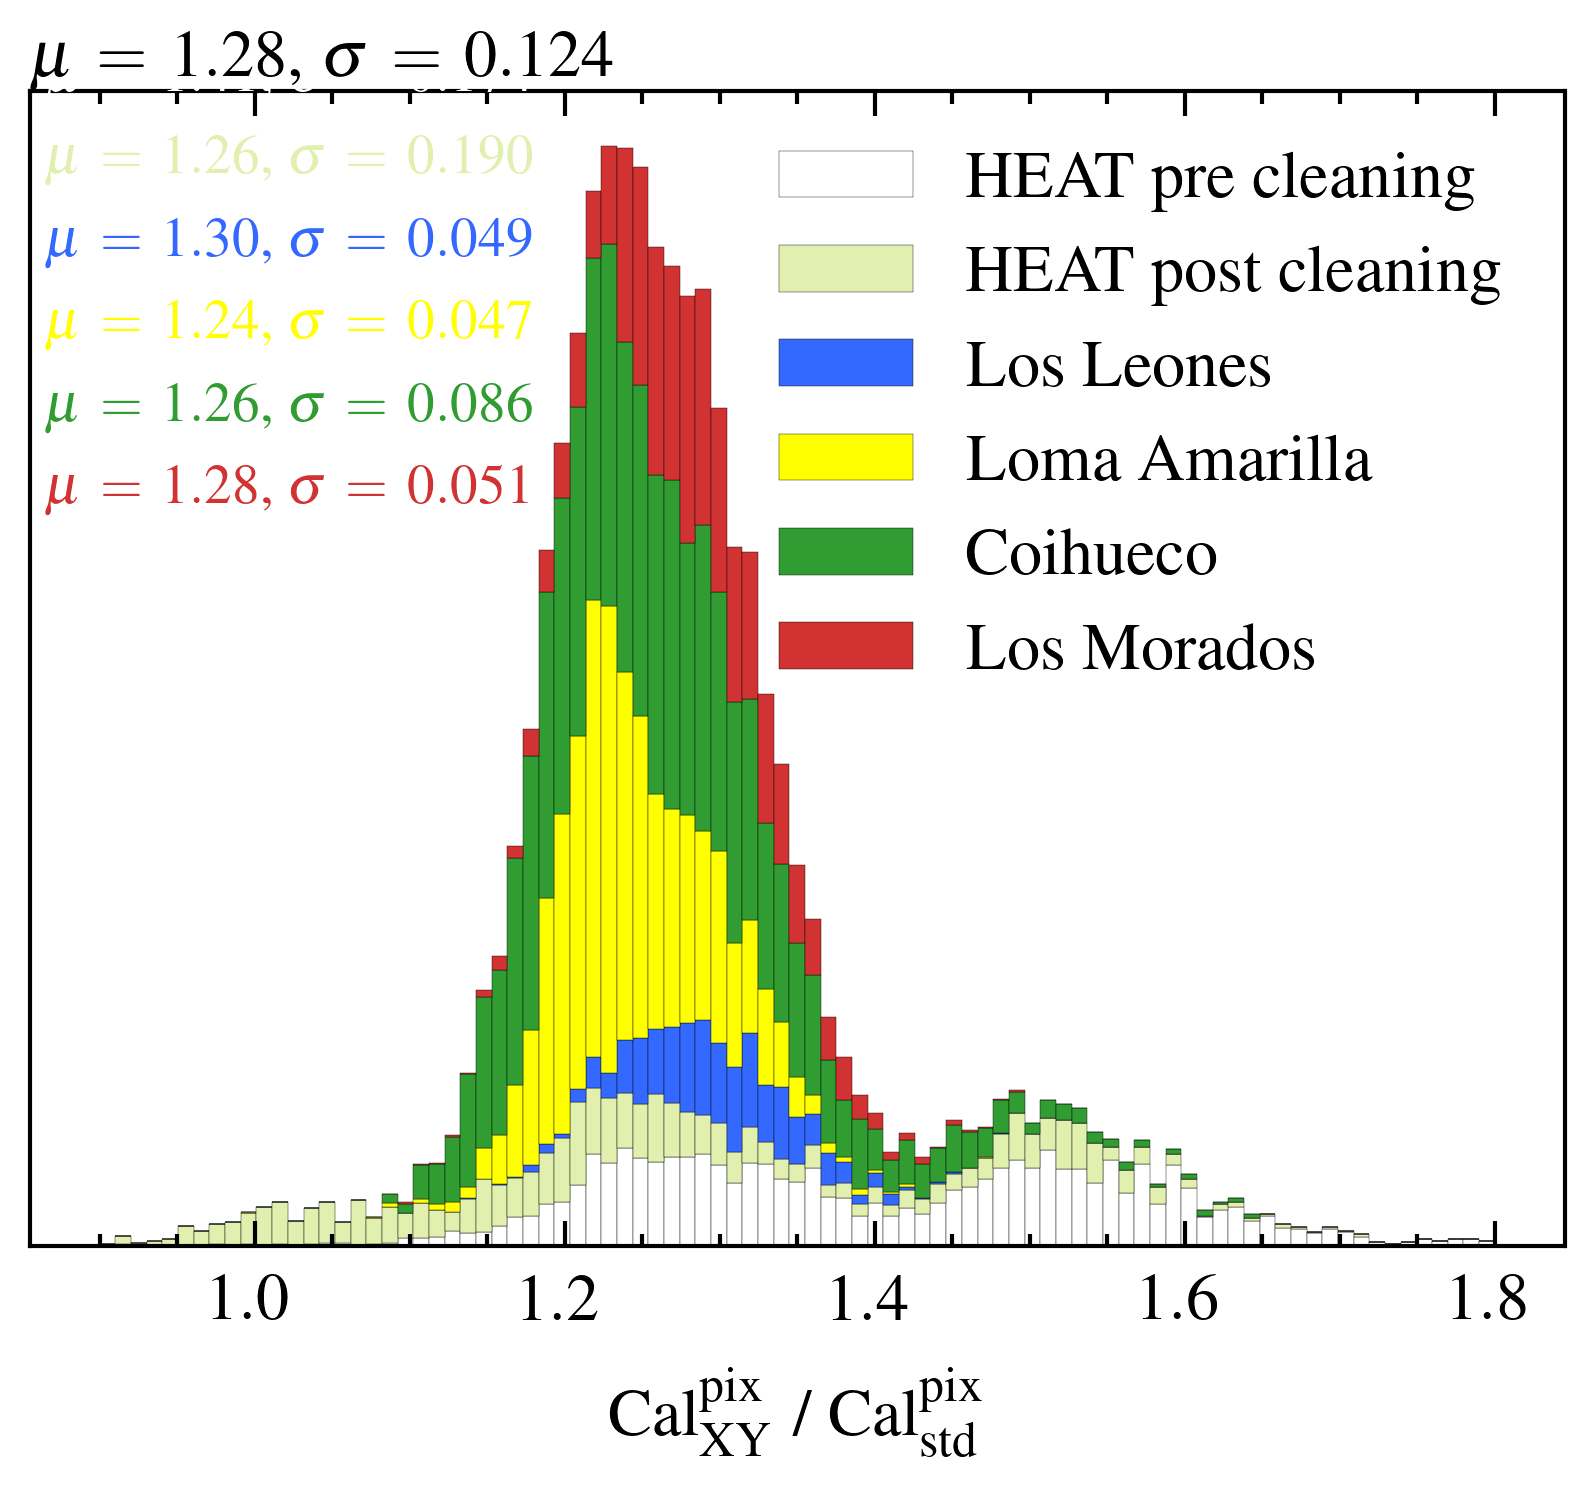

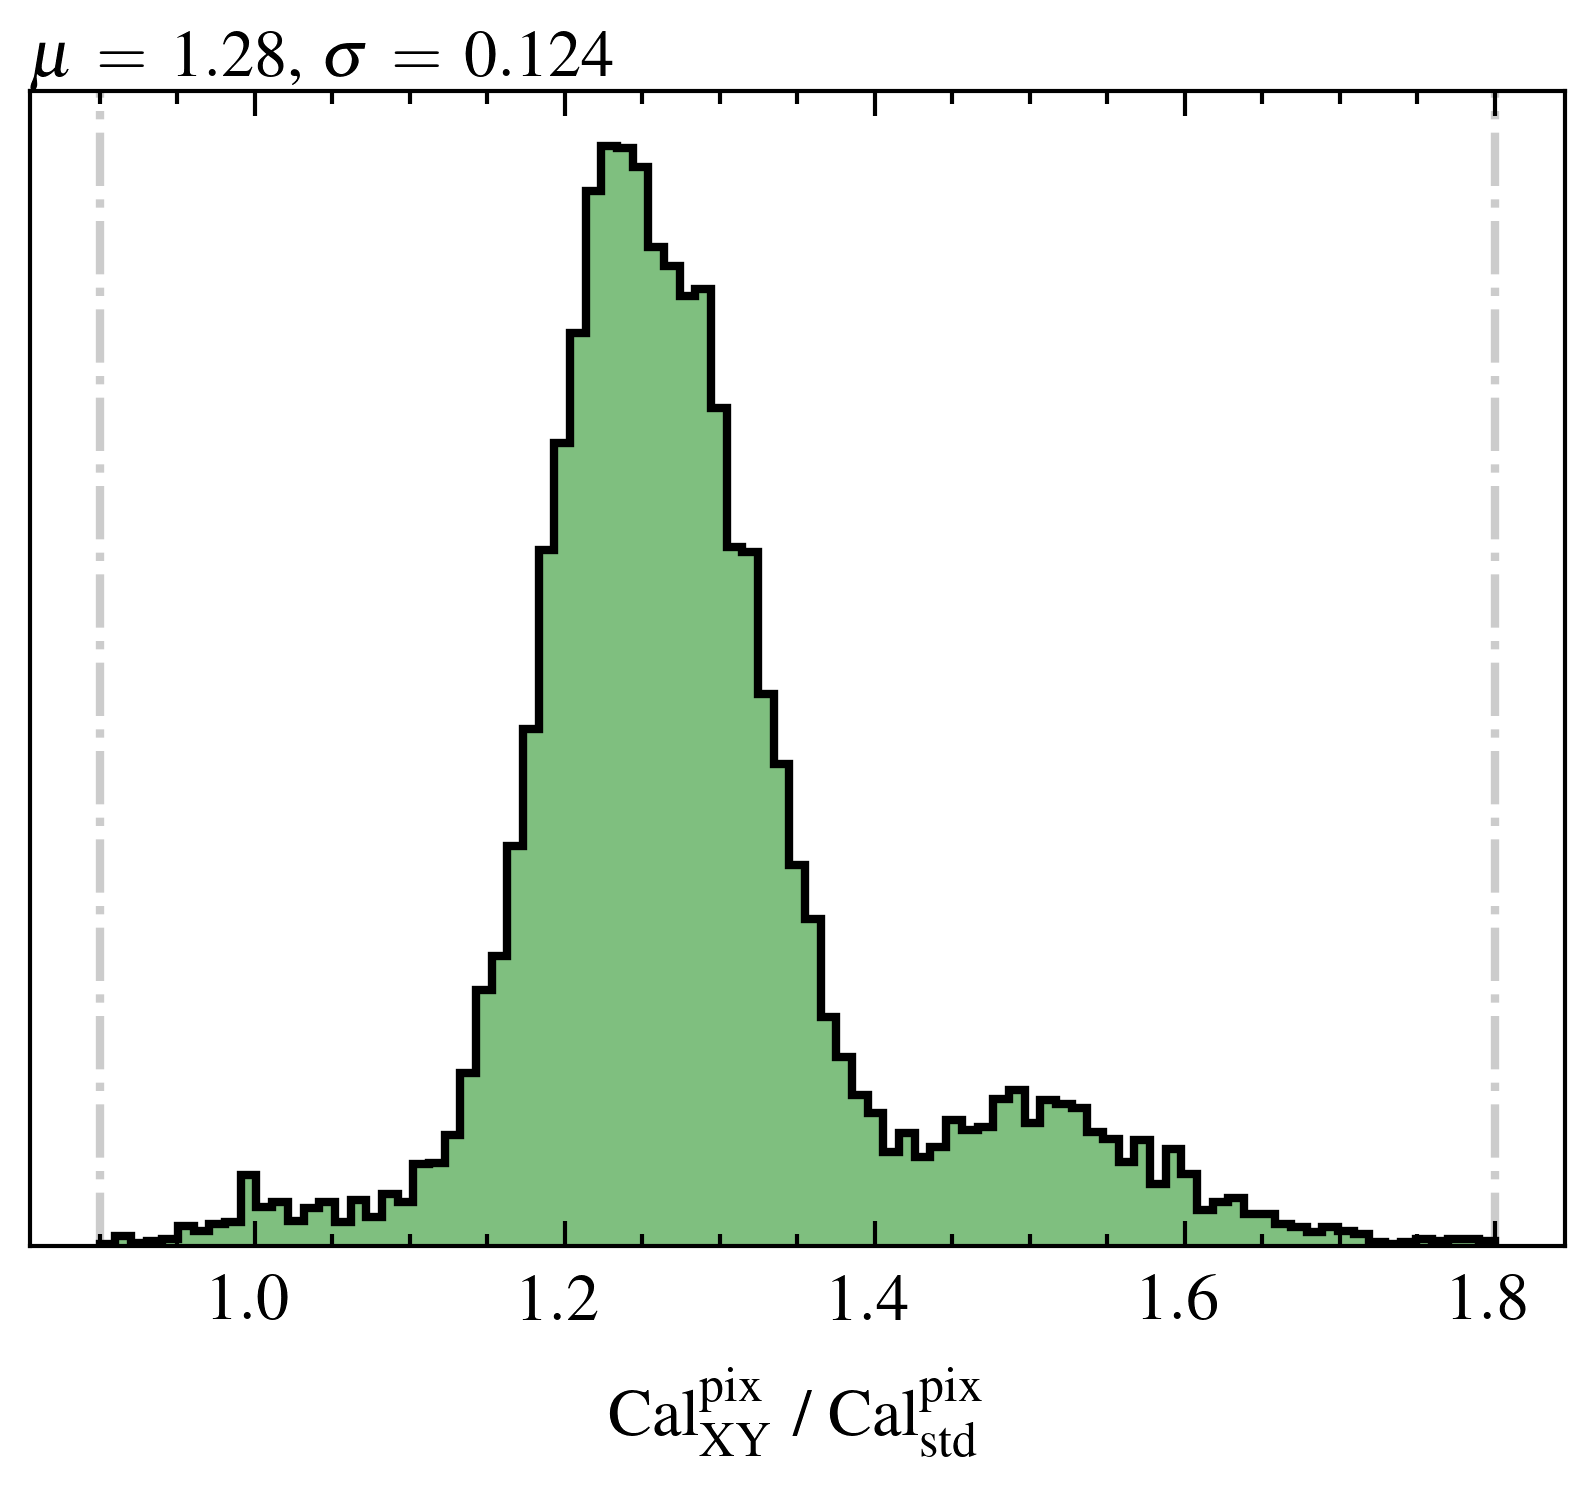

In [30]:
# std. calib

std_calib_bins = np.linspace(0.9, 1.8, 90)

std_calib_ratios = np.array(std_calib_ratios)
std_calib_ratios[~np.isfinite(std_calib_ratios)] = 1
colors = [r'#ffffff', '#e1efaf', '#3469ff', '#ffff00', '#319c31', '#d13232']
# colors = ['w' for _ in range(6)]

# for telescope, runs in tel_std_calib_ratios.items():
#     _ = plt.hist(runs, bins=std_calib_bins, histtype='step', label=telescope)
plt.xlabel(r'Cal$^\mathrm{pix}_\mathrm{XY}$ / Cal$^\mathrm{pix}_\mathrm{std}$')
_ = plt.hist(tel_std_calib_ratios.values(), bins=std_calib_bins, 
             histtype='barstacked', label=list(tel_std_calib_ratios.keys()),
             color=colors, edgecolor='k', lw=0.05, hatch=['/', '-', '\\', '|', '+'])

for i, (c, x) in enumerate(zip(colors, tel_std_calib_ratios.values())):
    x = np.array(x)[np.isfinite(x)]
    plt.text(0.01, 1 - i/14,
        rf'$\mu\,=\,{np.nanmean(x):.2f}$, $\sigma\,=\,{np.nanstd(x):.3f}$',
        transform=plt.gca().transAxes,
        fontsize='small',
        color=c
    )
std_calib_ratios = np.array(std_calib_ratios)[np.isfinite(std_calib_ratios)]
plt.text(0, 1, 
            rf"$\mu\,=\,{np.nanmean(std_calib_ratios):.2f}$, $\sigma\,=\,{np.nanstd(std_calib_ratios):.3f}$",
            transform=plt.gca().transAxes,
            ha='left',
            va='bottom')

# _ = plt.hist(tel_std_calib_ratios['HEAT post cleaning'], bins=std_calib_bins,
#              histtype='step', label='HEAT')
plt.yticks([])
plt.legend()

plt.figure()
_ = select_hist(std_calib_ratios, bins=std_calib_bins, cuts=[0.9, 1.8])
plt.xlabel(r'Cal$^\mathrm{pix}_\mathrm{XY}$ / Cal$^\mathrm{pix}_\mathrm{std}$')
plt.yticks([])
plt.legend()

